# Классификатор цветов по фото

## Импортируем модули с нужными библиотеками

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Загружаем данные

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")  # Узнаем объем датасета

Всего изображений: 3670


In [ ]:
batch_size = 32  # задаем объем одновременного объема данных, с которыми будет работать модель
img_width = 180
img_height = 180

# Прописываем параметры разделения тренировочного датасета
train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

# Прописываем параметры разделения тестового датасета
val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")  # Перечислим названия классов

# кешируем датасеты
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# создаем модель:
num_classes = len(class_names)
model = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# компилируем модель
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# вывод итоговых показателей модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Обучим нейросеть и выведем графики точности

Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.4643 - accuracy: 0.8345 - val_loss: 0.9577 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 105s 1s/step - loss: 0.2866 - accuracy: 0.9063 - val_loss: 1.0733 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 111s 1s/step - loss: 0.1644 - accuracy: 0.9489 - val_loss: 1.2937 - val_accuracy: 0.6403
Epoch 8/10
92/92 [==============================] - 103s 1s/step - loss: 0.0950 - accuracy: 0.9745 - val_loss: 1.4482 - val_accuracy: 0.6580
Epoch 9/10
92/92 [==============================] - 102s 1s/step - loss: 0.0796 - accuracy: 0.9792 - val_loss: 1.5815 - val_accuracy: 0.6308
Epoch 10/10
92/92 [==============================] - 105s 1s/step - loss: 0.0684 - accuracy: 0.9816 - val_loss: 1.7477 - val_accuracy: 0.6526


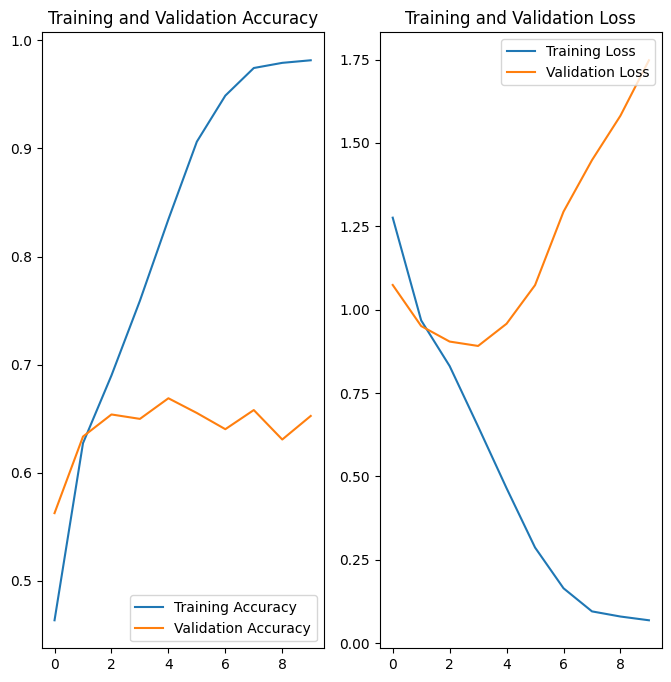

In [ ]:
# тренируем модель
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# визуализируем точность модели на тренировочных и тестовых данных
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Смотря на графики, видно, что по мере увеличения эпох точность предсказаний на тренировочном датасете (Training Accuracy) становится 100%, в то время как точность предсказаний на проверочном датасете (Validation Accuracy) практически не изменяется и колеблется возле 67%, а величина ошибки на проверочном датасете значительно увеличивается по мере числа эпох.
Приходим к выводу - модель переобучена!
Как это решить? Один из очевидных способов увеличить размер тренировочного датасета (добавить параметры аугментации) и повысить штраф за увеличение сложности мат. модели (добавить пармаметр регуляризации в нашу модель).

In [ ]:
model = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# компилируем модель
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# выведем предысторию
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

## Увеличим число эпох и обучим нейросеть применив аугментацию и регуляризацию

Epoch 1/20
92/92 [==============================] - 123s 1s/step - loss: 1.2790 - accuracy: 0.4547 - val_loss: 1.1485 - val_accuracy: 0.5245
Epoch 2/20
92/92 [==============================] - 118s 1s/step - loss: 1.0567 - accuracy: 0.5811 - val_loss: 0.9901 - val_accuracy: 0.6117
Epoch 3/20
92/92 [==============================] - 120s 1s/step - loss: 0.9739 - accuracy: 0.6076 - val_loss: 0.9326 - val_accuracy: 0.6199
Epoch 4/20
92/92 [==============================] - 122s 1s/step - loss: 0.9221 - accuracy: 0.6413 - val_loss: 0.8829 - val_accuracy: 0.6676
Epoch 5/20
92/92 [==============================] - 122s 1s/step - loss: 0.8401 - accuracy: 0.6754 - val_loss: 0.7961 - val_accuracy: 0.6812
Epoch 6/20
92/92 [==============================] - 121s 1s/step - loss: 0.7809 - accuracy: 0.7013 - val_loss: 0.8169 - val_accuracy: 0.6894
Epoch 7/20
92/92 [==============================] - 120s 1s/step - loss: 0.7713 - accuracy: 0.6982 - val_loss: 0.8575 - val_accuracy: 0.6594
Epoch 8/20
92

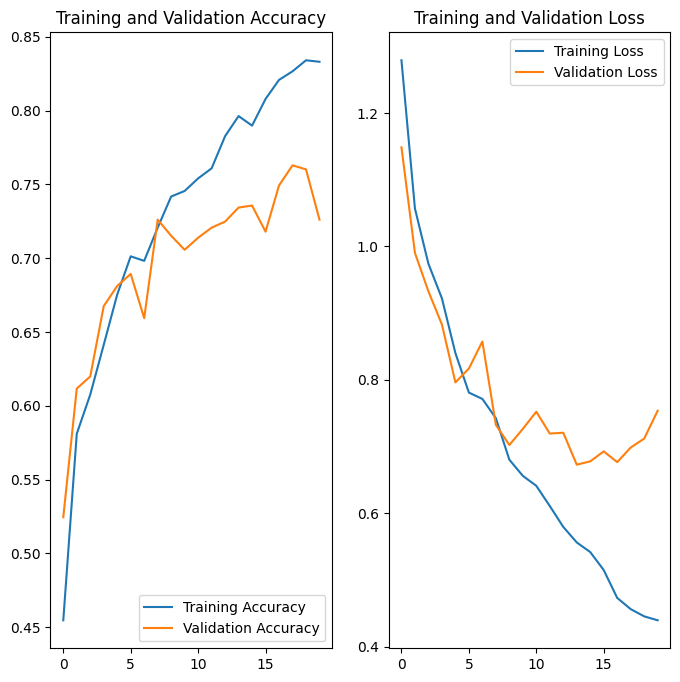

In [ ]:
# тренируем модель
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# визуализируем точность модели на тренировочных и тестовых данных
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Смотря на графики, видим, что предсказательная точность нейросети на тестовых данных увеличилась на до 76% (максимум функции, т. е. примерно на 9% относительно прошлых результатов). Величина ошибки также уменьшилась.

In [ ]:
from google.colab import files

model_file_name = "my_flowers_model.h5"

# сохраняем модель
model.save(model_file_name)

# загружаем модель себе на компьютер
files.download(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Сделаем проверку на случайном изображении цветка из Интернета

In [ ]:
# Загрузка фото
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Делаем предсказания
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Выведем предсказание для случайной картинки
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# Показать изображения
img.show()

1/1 [==============================] - 0s 261ms/step
На изображении скорее всего sunflowers (99.43% вероятность)
